## Import Library

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Data Preparation

In [2]:
data_path=r"E:\Dropbox (Personal)\BootCamp\projek\Project_FaceR"

In [3]:

print(os.listdir(data_path))


['.ipynb_checkpoints', 'best_googlenet_gender.pth', 'class_identity.txt', 'CRISP_MLQ_Presentasi_Klasifikasi_Gender.pptx', 'gender_subset.csv', 'GoogleNet.ipynb', 'GoogleNet_1.ipynb', 'GoogleNet_1_cleaned.ipynb', 'Images', 'inference_gnet.ipynb', 'list_attribute - Copy.txt', 'list_attribute.txt', 'model', 'photo', 'Presentasi_Klasifikasi_Gender_GoogLeNet.pptx', 'Untitled.ipynb', 'Untitled1.ipynb', 'VGG_GoogleNet_ResNet_(Template).ipynb']


In [4]:
images_list = os.listdir(data_path+'/Images')

In [5]:
print(images_list[:10])



['000051.jpg', '000052.jpg', '000065.jpg', '000166.jpg', '000198.jpg', '000201.jpg', '000240.jpg', '000282.jpg', '000352.jpg', '000409.jpg']


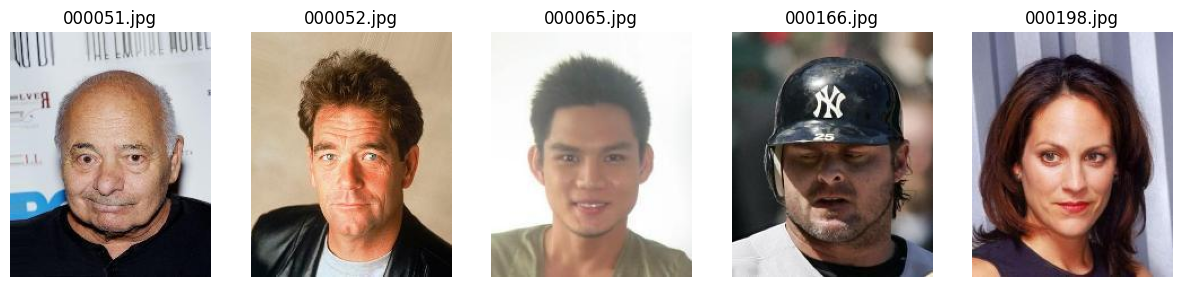

In [6]:
sample_files = images_list[:5]

plt.figure(figsize=(15,5))
for i, fname in enumerate(sample_files):
    img_path = os.path.join(data_path, "Images", fname)
    img = Image.open(img_path)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis("off")

plt.show()

In [7]:
print("Jumlah gambar:", len(images_list))

Jumlah gambar: 5000


In [8]:
images_dir = os.path.join(data_path, "Images")
images_list = sorted(os.listdir(images_dir))

In [9]:


images_dir = os.path.join(data_path, "Images")

# ambil semua file di folder
all_files = os.listdir(images_dir)

# hapus semua file yang punya tanda kurung (biasanya duplikat: (1), (2), ...)
deleted = 0
for f in all_files:
    if "(" in f:   # deteksi duplikat
        os.remove(os.path.join(images_dir, f))
        deleted += 1

print(f"Total file dihapus: {deleted}")
print("Total file tersisa:", len(os.listdir(images_dir)))


Total file dihapus: 0
Total file tersisa: 5000


In [10]:


# path file attribute dan folder image
attr_file = os.path.join(data_path, "list_attribute.txt")
images_dir = os.path.join(data_path, "Images")

# 1️⃣ baca attribute file
attrs = pd.read_csv(attr_file, sep="\s+", skiprows=1, index_col=0)

# 2️⃣ ambil kolom 'Male' dan ubah -1 → 0 (female), 1 → 1 (male)
labels = attrs[['Male']].copy()
labels['Male'] = labels['Male'].map({-1:0, 1:1})

# 3️⃣ ambil daftar gambar yang benar-benar ada
images_list = os.listdir(images_dir)
print("Total gambar di folder:", len(images_list))

# 4️⃣ filter hanya baris yang filenya tersedia di folder
labels_subset = labels[labels.index.isin(images_list)].copy()

# 5️⃣ tambahkan kolom path gambar
labels_subset['image_path'] = labels_subset.index.map(lambda fname: os.path.join(images_dir, fname))

# 6️⃣ simpan ke CSV
output_csv = os.path.join(data_path, "gender_subset.csv")
labels_subset.to_csv(output_csv, index=True)

print(f"\n✅ CSV label tersimpan di: {output_csv}")
print("Total data disimpan:", len(labels_subset))
print(labels_subset.head())


Total gambar di folder: 5000

✅ CSV label tersimpan di: E:\Dropbox (Personal)\BootCamp\projek\Project_FaceR\gender_subset.csv
Total data disimpan: 5000
            Male                                         image_path
000051.jpg     1  E:\Dropbox (Personal)\BootCamp\projek\Project_...
000052.jpg     1  E:\Dropbox (Personal)\BootCamp\projek\Project_...
000065.jpg     1  E:\Dropbox (Personal)\BootCamp\projek\Project_...
000166.jpg     1  E:\Dropbox (Personal)\BootCamp\projek\Project_...
000198.jpg     0  E:\Dropbox (Personal)\BootCamp\projek\Project_...


In [11]:
# split the data into train and test sets with a 80:20 ratio

from sklearn.model_selection import train_test_split

# path ke csv hasil sebelumnya
csv_path = os.path.join(data_path, "gender_subset.csv")

# baca data csv
df = pd.read_csv(csv_path, index_col=0)

# split 80:20 (pakai stratify supaya proporsi Male/Female tetap seimbang)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["Male"],
    random_state=42
)

print("Total data:", len(df))
print("Train data:", len(train_df))
print("Test data :", len(test_df))
print("\nDistribusi Train:\n", train_df["Male"].value_counts())
print("\nDistribusi Test:\n", test_df["Male"].value_counts())


Total data: 5000
Train data: 4000
Test data : 1000

Distribusi Train:
 Male
0    2362
1    1638
Name: count, dtype: int64

Distribusi Test:
 Male
0    591
1    409
Name: count, dtype: int64


## Preprocessing

In [12]:
# ============================================================
# 📦 Dataset & Data Augmentation untuk GoogLeNet
# ============================================================
from torch.utils.data import Dataset, DataLoader

# ============================================================
# 🎨 Transformasi Data
# ============================================================

# Augmentasi hanya untuk data training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),       # potongan acak dari area gambar
    transforms.RandomHorizontalFlip(p=0.5),                    # cerminkan kiri-kanan
    transforms.RandomRotation(degrees=15),                     # rotasi ringan
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # variasi pencahayaan
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformasi standar untuk validasi / testing (tanpa augmentasi)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),                     # ubah ukuran ke 224x224
    transforms.ToTensor(),                             # ubah ke tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # normalisasi sesuai ImageNet
                         std=[0.229, 0.224, 0.225])
])

# ============================================================
# 🧩 Custom Dataset Class
# ============================================================

class GenderDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        label = int(self.df.iloc[idx]["Male"])
        
        # Buka gambar dan konversi ke RGB
        img = Image.open(img_path).convert("RGB")
        
        # Terapkan transformasi
        if self.transform:
            img = self.transform(img)
        
        return img, label

# ============================================================
# 🧠 Inisialisasi Dataset
# ============================================================

train_dataset = GenderDataset(train_df, transform=train_transform)
test_dataset  = GenderDataset(test_df,  transform=test_transform)



In [13]:
# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print("Total batch (train):", len(train_loader))
print("Total batch (test) :", len(test_loader))


Total batch (train): 250
Total batch (test) : 63


## Architecture

## Modeling

In [14]:

from torchvision import models

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1️⃣ Load GoogleNet pretrained
model = models.googlenet(pretrained=True)

# 2️⃣ Freeze semua layer dulu (optional, hanya fine-tune bagian akhir)
for param in model.parameters():
    param.requires_grad = False

# 3️⃣ Ganti layer FC terakhir jadi 2 kelas (female, male)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# 4️⃣ Kirim model ke GPU/CPU
model = model.to(device)



print(model.fc)


Device: cuda


E:\Dropbox (Personal)\BootCamp\Win\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Dropbox (Personal)\BootCamp\Win\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=1024, out_features=2, bias=True)


In [15]:

from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time, os

# 🔧 Hyperparameters
num_epochs = 100
best_acc = 0.0

# Tentukan loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# ✅ Scheduler untuk turunkan learning rate setiap 5 epoch (dikali 0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

lrs = []
print("Initial LR:", optimizer.param_groups[0]['lr'])

# List untuk menyimpan data tiap epoch
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Timer total training
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # ===== TRAINING =====
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

    # ===== VALIDATION =====
    model.eval()
    test_loss = 0.0
    test_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

    val_loss = test_loss / len(test_dataset)
    val_acc = test_corrects.double() / len(test_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

    # Simpan model terbaik berdasarkan val_acc
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(data_path, "best_googlenet_gender.pth"))

    #print(f"Current LR: {optimizer.param_groups[0]['lr']:.8f}")    

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    print(f"Current LR: {current_lr:.8f}")


# Hitung total durasi
end_time = time.time()
duration = end_time - start_time
m, s = divmod(duration, 60)
h, m = divmod(m, 60)

print(f"\nTraining selesai ✅ — Akurasi terbaik: {best_acc:.4f}")
print(f"⏱️ Total waktu pelatihan: {int(h)} jam {int(m)} menit {int(s)} detik")



Initial LR: 0.001

Epoch 1/100
--------------------
Train Loss: 0.3968  Acc: 0.8313
Val Loss: 0.3135  Acc: 0.8590
Current LR: 0.00100000

Epoch 2/100
--------------------
Train Loss: 0.3220  Acc: 0.8613
Val Loss: 0.2894  Acc: 0.8730
Current LR: 0.00100000

Epoch 3/100
--------------------
Train Loss: 0.2979  Acc: 0.8718
Val Loss: 0.2591  Acc: 0.9000
Current LR: 0.00100000

Epoch 4/100
--------------------
Train Loss: 0.3009  Acc: 0.8695
Val Loss: 0.2549  Acc: 0.8940
Current LR: 0.00100000

Epoch 5/100
--------------------
Train Loss: 0.2964  Acc: 0.8708
Val Loss: 0.2825  Acc: 0.8800
Current LR: 0.00100000

Epoch 6/100
--------------------
Train Loss: 0.2981  Acc: 0.8698
Val Loss: 0.2635  Acc: 0.8950
Current LR: 0.00100000

Epoch 7/100
--------------------
Train Loss: 0.3053  Acc: 0.8658
Val Loss: 0.2535  Acc: 0.8950
Current LR: 0.00100000

Epoch 8/100
--------------------
Train Loss: 0.3045  Acc: 0.8702
Val Loss: 0.2542  Acc: 0.8920
Current LR: 0.00100000

Epoch 9/100
-----------------

## Evaluation

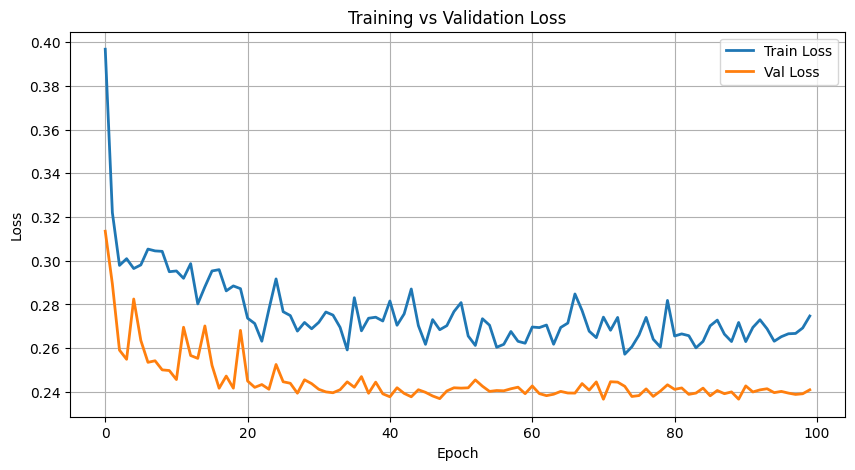

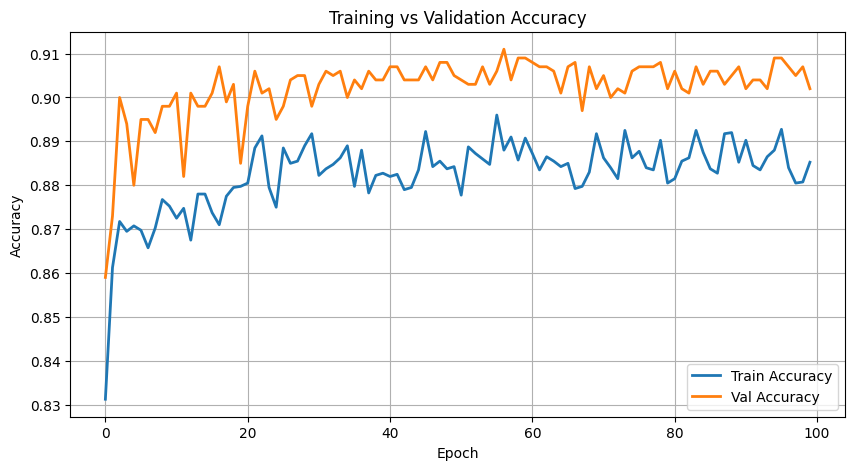

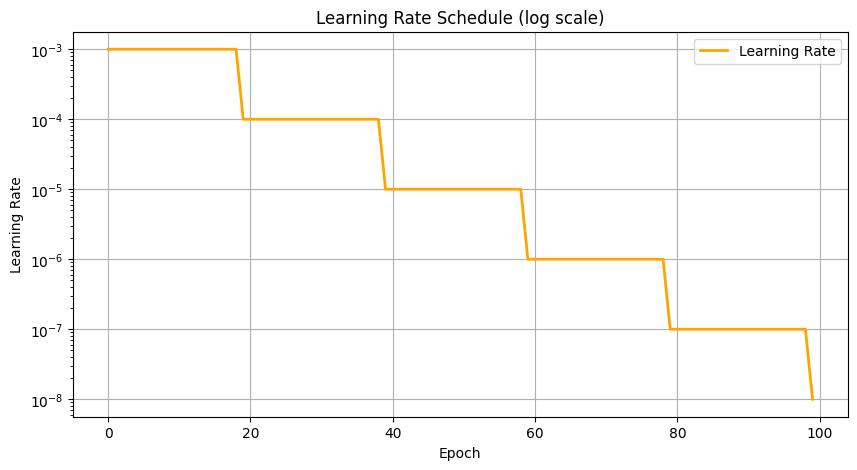

In [16]:
import matplotlib.pyplot as plt

# --- Grafik Loss ---
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Simpan grafik Loss
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Grafik Accuracy ---
plt.figure(figsize=(10,5))
plt.plot(train_accs, label='Train Accuracy', linewidth=2)
plt.plot(val_accs, label='Val Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Simpan grafik Accuracy
plt.savefig('training_validation_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Grafik Learning Rate ---
plt.figure(figsize=(10,5))
plt.plot(lrs, label='Learning Rate', color='orange', linewidth=2)
plt.yscale('log')  # tampilkan dalam skala logaritmik
plt.title('Learning Rate Schedule (log scale)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

# Simpan grafik Learning Rate
plt.savefig('learning_rate_schedule.png', dpi=300, bbox_inches='tight')
plt.show()


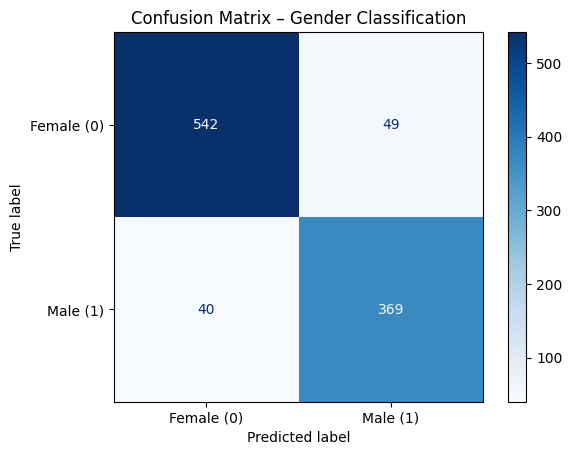


Classification Report:
              precision    recall  f1-score   support

      Female       0.93      0.92      0.92       591
        Male       0.88      0.90      0.89       409

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



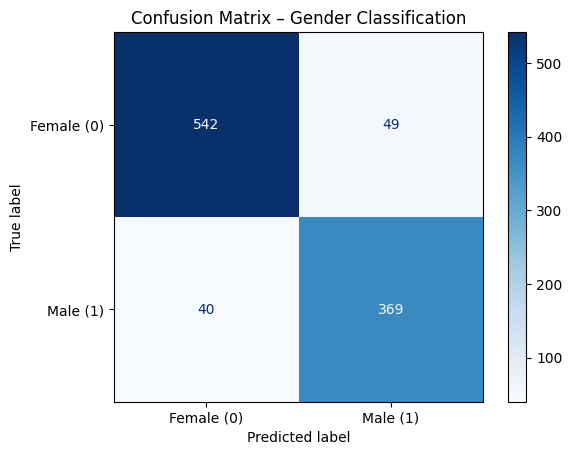

In [18]:
#Evaluasi Model – Confusion Matrix & Classification Report

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# 🔹 Load model terbaik
model.load_state_dict(torch.load(os.path.join(data_path, "best_googlenet_gender.pth")))
model.eval()

# 🔹 Kumpulkan prediksi dan label sebenarnya
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 🔹 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female (0)", "Male (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Gender Classification")
plt.show()

# 🔹 Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Female", "Male"]))

# 🔹 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female (0)", "Male (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Gender Classification")

# 💾 Simpan sebagai file gambar (tambahan penting)
plt.savefig("confusion_matrix.png", bbox_inches="tight", dpi=300)

plt.show()



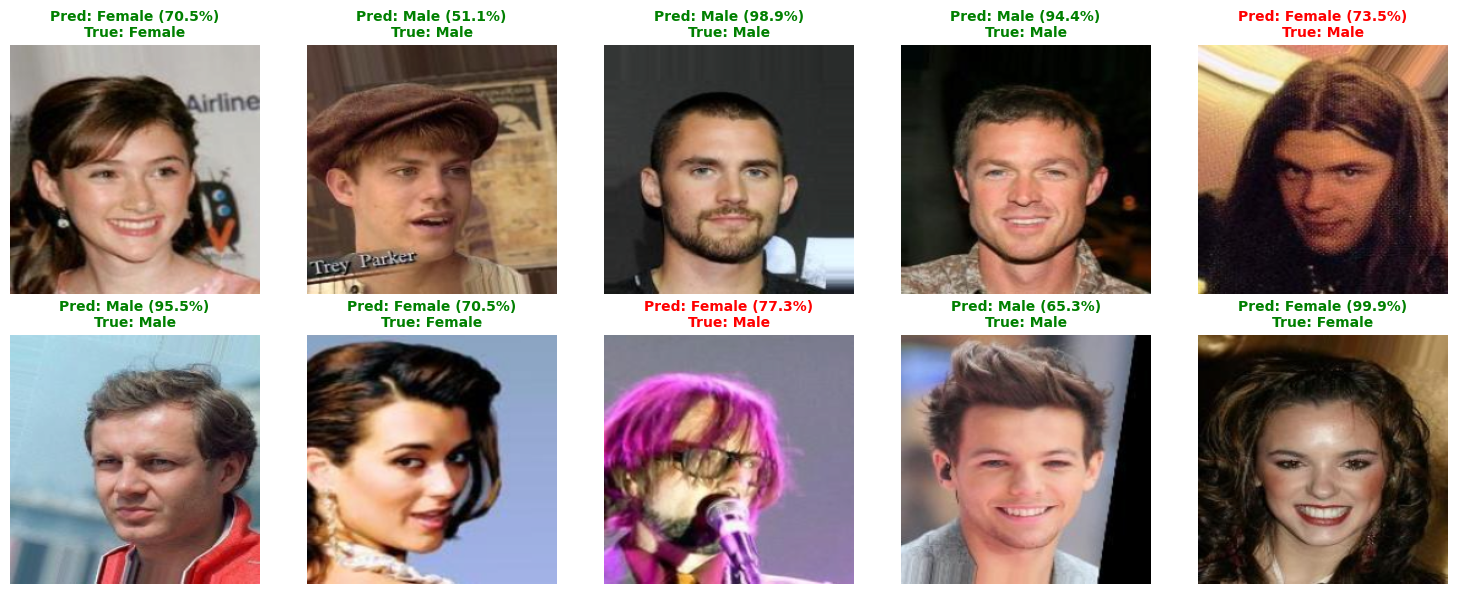

In [19]:

import torch.nn.functional as F

import random
import numpy as np

def denormalize(img_tensor):
    """Kembalikan tensor gambar ke format normal [0–1]"""
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Ambil batch acak dari test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Tentukan jumlah gambar untuk ditampilkan
num_samples = 10
idxs = random.sample(range(len(images)), num_samples)
images, labels = images[idxs], labels[idxs]

# Prediksi dan hitung confidence
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    probs = F.softmax(outputs, dim=1)  # hitung probabilitas
    confs, preds = torch.max(probs, 1)  # ambil nilai dan label tertinggi

# --- Tampilkan hasil ---
cols = 5
rows = (num_samples + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))

for i in range(num_samples):
    img = denormalize(images[i])
    pred_label = 'Male' if preds[i] == 1 else 'Female'
    true_label = 'Male' if labels[i] == 1 else 'Female'
    conf = confs[i].item() * 100  # ubah ke persen

    # Warna judul
    color = "green" if preds[i] == labels[i] else "red"

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {pred_label} ({conf:.1f}%)\nTrue: {true_label}",
              color=color, fontsize=10, weight="bold")

plt.tight_layout()
plt.show()




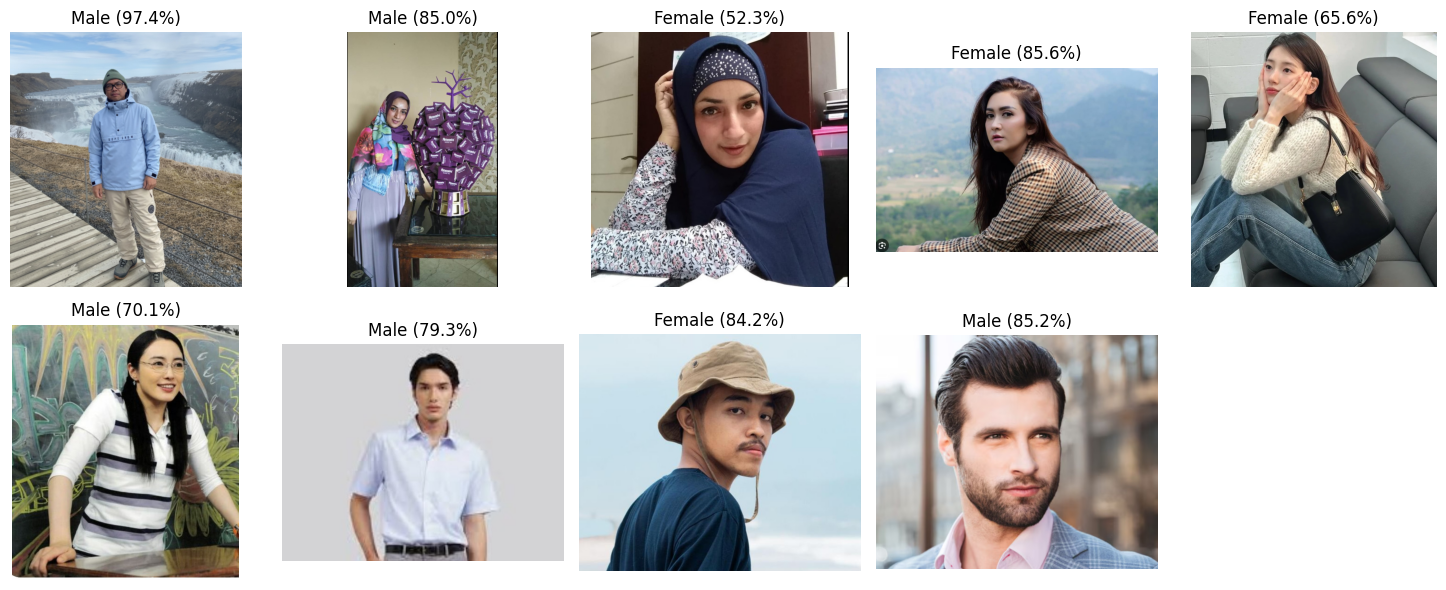

In [22]:

from torchvision import transforms
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Folder berisi gambar
folder_path = r"E:\Dropbox (Personal)\BootCamp\projek\Project_FaceR\photo"

# Transform harus sama seperti saat training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load semua gambar dari folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

images = []
original_imgs = []
for file in image_files[:10]:  # misal ambil 10 gambar dulu
    img_path = os.path.join(folder_path, file)
    img = Image.open(img_path).convert("RGB")
    original_imgs.append(img)
    images.append(transform(img))

# Gabungkan semua jadi satu tensor batch
inputs = torch.stack(images).to(device)

# Prediksi batch
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    probs = F.softmax(outputs, dim=1)
    confs, preds = torch.max(probs, 1)

# --- Visualisasi hasil ---
cols = 5
rows = (len(images) + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))

for i in range(len(images)):
    label = "Male" if preds[i] == 1 else "Female"
    conf = confs[i].item() * 100
    plt.subplot(rows, cols, i + 1)
    plt.imshow(original_imgs[i])
    plt.axis("off")
    plt.title(f"{label} ({conf:.1f}%)")

plt.tight_layout()
plt.show()
